In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('./results4.csv')
df.columns = ['id', 'text', 'modText', 'sentiment', 'topics', 'hashtags']

chosenId = "64EA9B6D-AA62-ED11-B67D-D85ED3AE4DFE"

for i in range(0, len(df)):
    df['topics'][i] = df['topics'][i].replace("'',", "")
df['topics'] = df['topics'].apply(lambda x: x[1:-1].split(', '))

#apply knn on id based on topics
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df['topics'].apply(lambda x: ' '.join(x)))
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

knn = NearestNeighbors(n_neighbors=10, metric='cosine')
knn.fit(tfidf_matrix)

def get_recommendations(id, cosine_sim=cosine_sim):
    idx = df.index[df['id'] == id][0]
    distances, indices = knn.kneighbors(tfidf_matrix[idx], n_neighbors=10)
    return df.iloc[indices[0]]

get_recommendations(chosenId)

C:\Users\andre\AppData\Local\Temp\ipykernel_33148\4112635066.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['topics'][i] = df['topics'][i].replace("'',", "")


,id,text,modText,sentiment,topics,hashtags
2095,57B01778-A962-ED11-B67D-D85ED3AE4DFE,Stand by everything I said here obviously. The...,stand everyth said obvious peopl need thrown c...,4,[''],[]
2094,57B01778-A962-ED11-B67D-D85ED3AE4DFE,This is what I was reacting to by the way \r\n...,react,4,[''],[]
2098,64EA9B6D-AA62-ED11-B67D-D85ED3AE4DFE,"@WholeMarsBlog To assess if a drug is good, wh...",assess drug good whether legal illeg acid test...,0,"['Test', 'Legal']",[]
2097,64EA9B6D-AA62-ED11-B67D-D85ED3AE4DFE,@WholeMarsBlog Cocaine does not meet that test,cocain meet test,4,['Test'],[]
2096,57B01778-A962-ED11-B67D-D85ED3AE4DFE,Hmm I wonder why you didn't include the part w...,wonder includ part play clip half nake drag qu...,4,"['Kids', 'Sex']",[]
2100,64EA9B6D-AA62-ED11-B67D-D85ED3AE4DFE,@WholeMarsBlog Banning alcohol caused the bigg...,ban alcohol caus biggest rise organ crime amer...,0,"['Drugs', 'Crime']",[]
2091,57B01778-A962-ED11-B67D-D85ED3AE4DFE,This is a very dark and disturbing look at men...,dark disturb look mental ill,0,['Mental Illness'],[]
2092,57B01778-A962-ED11-B67D-D85ED3AE4DFE,This is an outrage and I would never wiggle ou...,outrag would never wiggl like except time,0,[''],[]
2101,64EA9B6D-AA62-ED11-B67D-D85ED3AE4DFE,Launch 61 of 2022. Congrats SpaceX! https://t....,launch congrat spacex,4,['Spacex'],[]
2093,57B01778-A962-ED11-B67D-D85ED3AE4DFE,@JasonSCampbell Do you think that event was ap...,think event appropri children,0,[''],[]


In [2]:
#remove "''," from topics
df['topics'] = df['topics'].apply(lambda x: [i.replace("'',", "") for i in x])

#get percentage of topics in each category
def get_percentage(df):
    topics = []
    for i in df['topics']:
        topics.extend(i)
    topics = pd.Series(topics)
    return topics.value_counts()/len(topics)

get_percentage(df)

''                0.210466
'EU'              0.014324
'Twitter'         0.013751
'Law'             0.012032
'News'            0.010504
                    ...   
'Religion'        0.000191
'Left'            0.000191
'Privacy'         0.000191
'@HouseGOP'       0.000191
 '@RihoTerras'    0.000191
Length: 1018, dtype: float64

In [3]:
from gensim.similarities import SparseTermSimilarityMatrix, WordEmbeddingSimilarityIndex
import gensim.downloader as api
from gensim.corpora import Dictionary
from gensim.models import KeyedVectors
from gensim.models import TfidfModel
from gensim.similarities import SoftCosineSimilarity
import numpy as np

userDF = pd.DataFrame(columns=['id', 'topics',])
userDF.id = df.id.unique()
#add all unique topics to userDF by id unless it is empty
for i in range(0, len(userDF)):
    userDF['topics'][i] = df[df['id'] == userDF['id'][i]]['topics'].sum()
    userDF['topics'][i] = [x for x in userDF['topics'][i] if x != "\'\'"]

#copy topics to new column without any reference to original dataframe
userDF['_topics'] = userDF['topics'].copy()

In [4]:
for i in range(0, len(userDF)):
    new_row = []

    for j in range(0, len(userDF['topics'][i])):
        new_row.append(userDF['topics'][i][j] + str((df[(df['id'] == userDF['id'][i]) & (df['topics'].apply(lambda x: userDF['topics'][i][j] in x))]['sentiment'].mean()).round(2)))
        
    userDF.at[i, 'topics'] = new_row 

In [5]:
#using soft cosine similarity return 10 most similar users to a given user
fasttext_model300 = api.load('fasttext-wiki-news-subwords-300')
documents = userDF['topics']
dictionary = Dictionary(documents)
bow_corpus = [dictionary.doc2bow(doc) for doc in documents]
index = WordEmbeddingSimilarityIndex(fasttext_model300)
sims = SparseTermSimilarityMatrix(index, dictionary)
model = SoftCosineSimilarity(bow_corpus, sims, num_best=10)

#assign user {number} to each user
userDF['user'] = ["user" + str(i) for i in range(0, len(userDF))]

100%|██████████| 1484/1484 [00:00<00:00, 419996.43it/s]


In [6]:
def get_recommendations(id):
    idx = userDF.index[userDF['id'] == id][0]
    query = userDF['topics'][idx]
    query = dictionary.doc2bow(query)
    return userDF.iloc[[i[0] for i in model[query]]]    
    
import plotly.graph_objects as go
    
recs = get_recommendations(chosenId)

#remove chosen user from recommendations
recs = recs[recs['id'] != chosenId]    

#plot a chart showing each user and the number of similar topics they have to the chosen user
#make table width fit to content
def plot_users(id, recs):
    fig = go.Figure(go.Table(
        header=dict(values=['User', 'Number of common topics'],
                    fill_color='paleturquoise',
                    align='left'),
        cells=dict(values=[recs['user'], recs['_topics'].apply(lambda x: len(set(x).intersection(set(userDF['_topics'][userDF['id'] == id].sum()))))],
                     fill_color='lavender',
                        align='left')))
    fig.update_layout(width=500, height=500)
    fig.show()
        
plot_users(chosenId, recs)

C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gensim\similarities\termsim.py:382: RuntimeWarning: divide by zero encountered in divide
  normalized_corpus = np.multiply(corpus, 1.0 / corpus_norm)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gensim\similarities\termsim.py:382: RuntimeWarning: invalid value encountered in multiply
  normalized_corpus = np.multiply(corpus, 1.0 / corpus_norm)


In [7]:
#plot silhouette score for different number of clusters with labels

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def plot_silhouette_score(df):
    scores = []
    for i in range(2, 10):
        kmeans = KMeans(n_clusters=i, random_state=0).fit(df)
        scores.append(silhouette_score(df, kmeans.labels_))
    fig = go.Figure(data=go.Scatter(x=[i for i in range(2, 10)], y=scores))
    fig.update_layout(title='User grouping KNN Silhouette Score',
                     xaxis_title='Number of Clusters',
                        yaxis_title='Silhouette Score')
    fig.show()
    
    
plot_silhouette_score(tfidf_matrix)

For n_clusters = 8 The average silhouette_score is : 0.21749391537295693


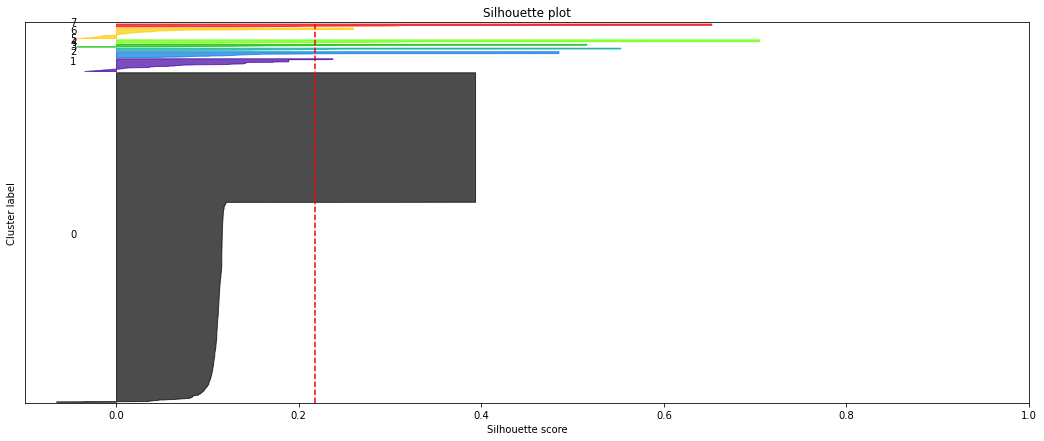

In [25]:
#plot silhuette plot

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def plot_silhouette(df, n_clusters):
    X = df
    y = KMeans(n_clusters=n_clusters, random_state=0).fit_predict(X)

    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("Silhouette plot")
    ax1.set_xlabel("Silhouette score")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])

    plt.show()
    
plot_silhouette(tfidf_matrix, 8)